# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель машинного обучения, которая определит приблизительный возраст человека. Для обучения модели был взят набор фотографий людей с сайта ChaLearn Looking at People.

План работы
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

### Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

CSV_PATH = '/datasets/faces/labels.csv'
IMG_PATH = '/datasets/faces/final_files/'
SEED = 42

In [2]:
df = pd.read_csv(CSV_PATH)

In [3]:
# инициализация загрузчика
datagen = ImageDataGenerator(rescale=1/255.)

# загрузка фотографий
train_datagen_flow = datagen.flow_from_dataframe(
    directory=IMG_PATH,
    dataframe=df,
    x_col='file_name',
    y_col='real_age',
    target_size=(200, 200),
    batch_size=32,
    class_mode='raw',
    seed=SEED)

features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


### Обзор данных

In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


**Вывод**

В ходе предварительного обзора можно сделать следующие выводы:
- Всего в датасете 7591 фотография и для каждой из них есть релаьный возраст человека;
- Пропусков не обнаружено;
- Реальный возраст не имеет выбросов, медианное значение равно 29 лет, среднее значение 31 год.

### Анализ реального возраста
Построим гистограмму распределения возраста людей среди фотографий.

In [10]:
def num_hist_box(data, feature):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,7))
    fig.suptitle(f'Распределение по {feature}')
    
    #Строим гистограмму
    sns.histplot(data, bins=50, x=feature, kde=True, ax=ax[0])
    ax[0].set(
        title=f'Гистограмма распределения по {feature}',
        xlabel=f'Значение {feature}',
        ylabel='Количество наблюдений')
    ax[0].grid()
    
    #Строим график разброса
    sns.boxplot(x=data[feature], ax=ax[1])
    ax[1].set(
        title=f'График разброса значений по {feature}',
        xlabel=f'Значение {feature}')
    
    plt.subplots_adjust(hspace = 0.5)

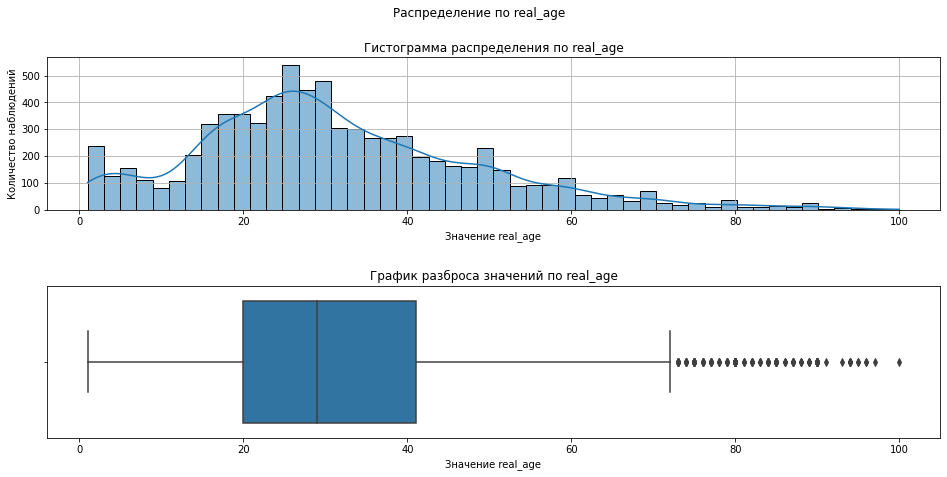

In [11]:
num_hist_box(df, 'real_age')

**Вывод**

Распределение возраста похоже на нормальное. Пик распределения смещен влево, но находится в пределах средних значений. Еще один пик находится в минимальных значениях возраста.

### Анализ изображений

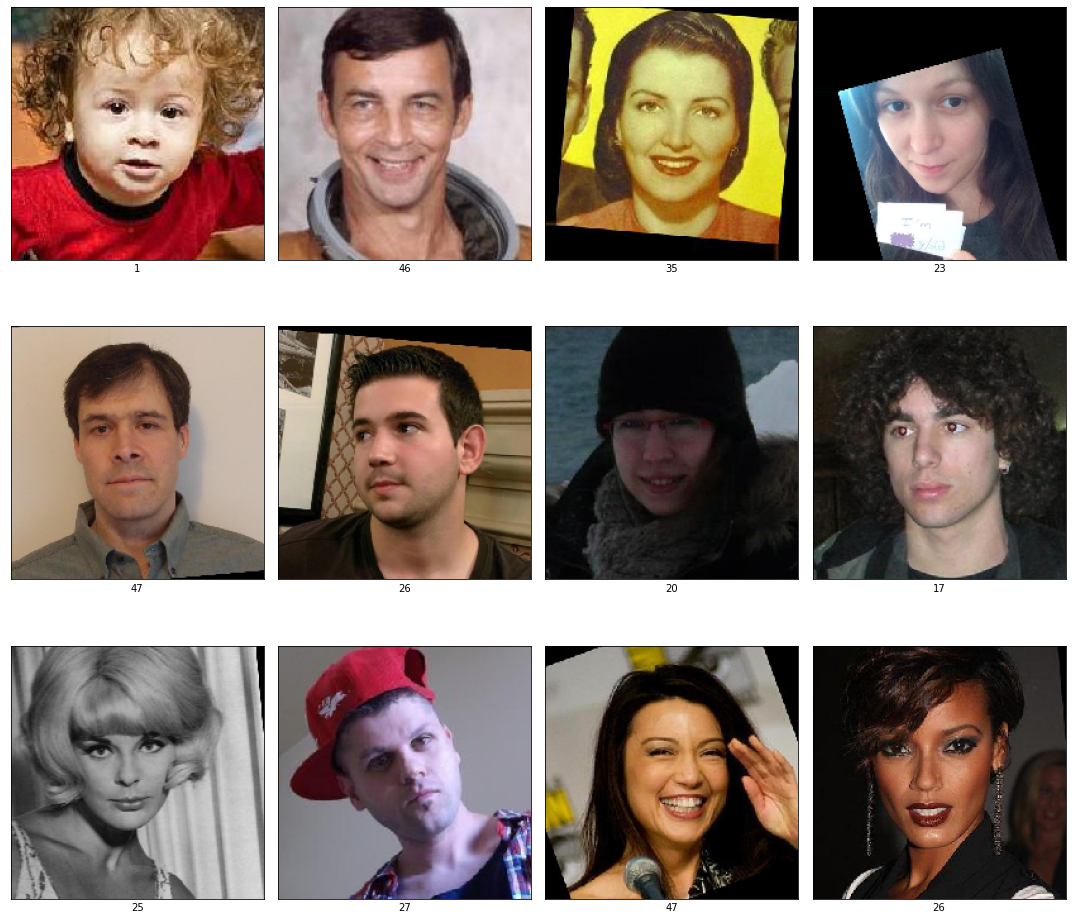

In [8]:
fig = plt.figure(figsize=(15, 15))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

В датасете содержатся различные фотографии: ч/б, цветные, разных временных промежутков. На всех фото видны лица, возраст соответствует человеку на фотографии.

### Вывод

В ходе исследовательского анализа можно сделать следующие выводы:
- Распределение возраста похоже на нормальное. Пик распределения смещен влево, но находится в пределах средних значений. Еще один пик находится в минимальных значениях возраста.
- В датасете содержатся различные фотографии: ч/б, цветные, разных временных промежутков. На всех фото видны лица, возраст соответствует человеку на фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1 / 255,
        validation_split=0.25
    )
    train_generator = train_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_generator

def load_test(path):
    valid_datagen = ImageDataGenerator(
        rescale=1 / 255,
        validation_split=0.25
    )
    valid_generator = valid_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
    return valid_generator

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)
    
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-12-19 08:59:51.032410: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-12-19 08:59:51.709172: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 137s - loss: 287.5534 - mae: 12.4775 - val_loss: 856.3441 - val_mae: 24.2782
Epoch 2/10
178/178 - 126s - loss: 132.4058 - mae: 8.6702 - val_loss: 624.8001 - val_mae: 19.6080
Epoch 3/10
178/178 - 128s - loss: 112.5816 - mae: 8.0417 - val_loss: 323.1941 - val_mae: 13.5059
Epoch 4/10
178/178 - 126s - loss: 98.4525 - mae: 7.5065 - val_loss: 250.8199 - val_mae: 12.1002
Epoch 5/10
178/178 - 125s - loss: 92.3790 - mae: 7.3067 - val_loss: 113.5848 - val_mae: 7.9517
Epoch 6/10
178/178 - 127s - loss: 85.8188 - mae: 6.9681 - val_loss: 114.6841 - val_mae: 7.9030
Epoch 7/10
178/178 - 128s - loss: 76.0210 - mae: 6.6814 - val_loss: 124.2503 - val_mae: 8.1892
Epoch 8/10
178/178 - 126s - loss: 74.0470 - mae: 6.4989 - val_loss: 118.9273 - val_mae: 8.3773
Epoch 9/10
178/178 - 127s - loss: 71.2634 - mae: 6.4348 - val_loss: 95.0940 - val_mae: 7.2243
Epoch 10/10
178/178 - 127s - loss: 64.5159 - mae: 6.1252 - val_loss: 89.7885 - val_mae: 7.1789
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 89.7885 - mae: 7.1789
```

## Анализ обученной модели

В ходе проекта была реализована модель архитектуры ResNet50 с алгоритмом оптимизации Adam и скоростью обучения 0.0001. При этом ошибка модели составляет 7.2 года. Это позволит отнести человека к определенной возрастной группе для формирования рекомендация, но для определения совершеннолетия покупателя необходима большая точность. Вероятно, такой разброс связан с тем, что в выборке больше людей молодого возраста (20-30 лет) и для модели недостаточно данных для других возрастов. Также данная неточность может быть связана с тем, что на фотографиях некоторых людей присутствуют и другие люди на фоне.

В целом цель модели достигнута, она предсказывает возраст со средней ошибкой 7.2, поэтому ее можно рекомендовать для анализа покупательской способности различных возрастных групп.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы